<img src='https://imgur.com/C5KY0E4.png'>
ref: https://imgur.com/C5KY0E4

# ROBOT NAVIGATION

Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.
In this Project, you’ll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

## How data was recorded

They have collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity. Succeed and you'll help improve the navigation of robots without assistance across many different surfaces, so they won’t fall down on the job.

## Data Overview

* **X_train.csv -** the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:<br>
    * **row_id:** The ID for this row.<br>
    * **series_id:** ID number for the measurement series. Foreign key to y_train/sample_submission.<br>
    * **measurement_number:** Measurement number within the series.<br>
<br>
* **orientation channels** encode the current angles how the robot is oriented as a quaternion (see Wikipedia)<br>
* **Angular velocity** describes the angle and speed of motion<br>
* **Linear acceleration** components describe how the speed is changing at different times.<br>
* The 10 sensor channels are:<br>
    * **orientation_X<br>**
    * **orientation_Y<br>**
    * **orientation_Z<br>**
    * **orientation_W<br>**
    * **angular_velocity_X<br>**
    * **angular_velocity_Y<br>**
    * **angular_velocity_Z<br>**
    * **linear_acceleration_X<br>**
    * **linear_acceleration_Y<br>**
    * **linear_acceleration_Z<br>**

* **y_train.csv -**  the surfaces for training set.
  * **series_id:** ID number for the measurement series.<br>
  * **group_id:** ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable       more cross validation strategies.<br>
  * **surface:** the target for this competition<br>

### Data Size : 
    * 48 MB


## Problem Framework

* We have 9 Different target variables and (128, 13) data for each data point.
* Each datapoint corresponds one of the 9 Surfaces.


## Problem Statement

 * Help robots to navigate by building classifier to predict the surface where robots are navigating 

In [6]:
#all imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels import robust
from scipy.stats import *
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import zipfile
import os
from scipy import fftpack

#reading data
data=pd.read_csv("X_train.csv")
c=list(data.columns)
y=list(pd.read_csv("y_train.csv")['surface'])
data.head(5)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [36]:
# basic info
print("Data Shape:",data.shape)
print("columns:",data.columns)

Data Shape: (487680, 13)
columns: Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')


In [37]:
#class lable
print("Target Labels:",y[0:8])

Target Labels: ['fine_concrete', 'concrete', 'concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc', 'concrete']


# Data Cleaning

## 1. Check for Duplicates

In [8]:
# checking  for duplicates
print('No of duplicates in data: {}'.format(sum(data.duplicated())))

No of duplicates in data: 0


## 2. Checking for NaN/null values

In [9]:
# checking for null or nan
print('We have {} NaN/Null values in data'.format(data.isnull().values.sum()))

We have 0 NaN/Null values in data


## 3. Check for data imbalance

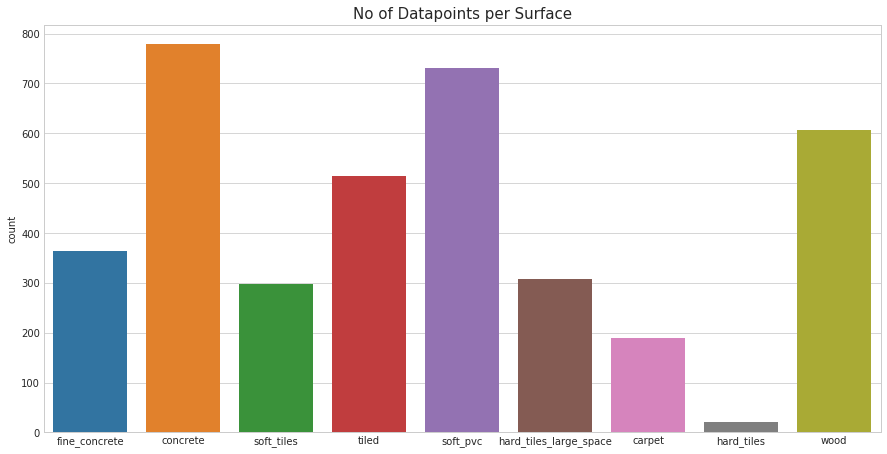

In [22]:
# plot to check distribution of classes with each subject
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(15,7.5))
plt.title('No of Datapoints per Surface', fontsize=15)
sns.countplot(y)
plt.show()

*  We have Slightly Imbalanced Dateset

# Engineering Statistical Features for each signals:

* **MEAN: ** Mean represents the central tendency of data, It is calculated by adding all the data points in a data and then dividing the total by the number of points.
* **MEDIAN: ** To find the median, we arrange the observations in order from smallest to largest value and the median is the middle value.
* **VARIANCE: ** This is one which represent the Measure of Spread of the data.
* **STD: ** The standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean of the set, while a high standard deviation indicates that the values are spread out over a wider range.
* **MAXIMUM:**: This is just the maximum of given Values.
* **MINIMUM:**: This is just the minimum of given Values.
* **IQR:** The Interquartile range (IQR) is a measure of variability, based on dividing a data set into quartiles, IQR is difference between First and Third quartiles.
* **COV:** The Coefficient of variation (COV) is a simple measure of relative event dispersion. It is equal to the ratio between the standard deviation and the mean.
* **SKEW:** Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative, or undefined
* **KURTOSIS:** Kurtosis is a measure of the "Tailedness" of the probability distribution of a real-valued random variable
* **MAD:** the Median absolute deviation (MAD) is a robust measure of the variability of a univariate sample of quantitative data, the MAD is defined as the median of the absolute deviations from the data's median

In [45]:
#function to extract statistical features 
def feature_extract(ar):
    mean=np.mean(ar)
    median=np.median(ar)
    variance=np.var(ar)
    std=np.std(ar)
    maximum=np.max(ar)
    minimum=np.min(ar)
    iqr=stats.iqr(ar)
    cov=stats.variation(ar)
    skew=stats.skew(ar)
    kurtosis=stats.kurtosis(ar)
    mad=robust.mad(ar)
    return [mean,median,variance,std,maximum,minimum,iqr,cov,skew,kurtosis,mad]

# preparing training data
final_feat=[]
for i in range(0,3810):
    df=data[(i*128):(i*128)+128]
    feat=[]
    for k in c[3:]:
        fe=feature_extract(df[k].to_numpy())
        for j in fe:
            feat.append(j)
    final_feat.append(feat)
    
#final data array
final_feat_array=np.array(final_feat)
print("statistical features extracted for data shape:",final_feat_array.shape)

statistical features extracted for data shape: (3810, 110)


In [28]:
# preparing column_names of statistical features.
col=['orientation_X' ,'orientation_Y','orientation_Z','orientation_W','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']
stat=['mean' ,'median', 'variance', 'std', 'maximum', 'minimum', 'iqr', 'cov', 'skew', 'kurtosis', 'mad']
column_names=[]
for i in col:
    for j in stat:
        column_names.append(("{}_{}".format(i,j)))
column_names[0:10]

['orientation_X_mean',
 'orientation_X_median',
 'orientation_X_variance',
 'orientation_X_std',
 'orientation_X_maximum',
 'orientation_X_minimum',
 'orientation_X_iqr',
 'orientation_X_cov',
 'orientation_X_skew',
 'orientation_X_kurtosis']

In [49]:
stat_data=pd.DataFrame(final_feat_array, columns=column_names)
stat_labels=pd.DataFrame(y, columns=["surface"])
final_stat_data=pd.merge(stat_data,stat_labels, left_index=True, right_index=True)
final_stat_data.head(5)

,orientation_X_mean,orientation_X_median,orientation_X_variance,orientation_X_std,orientation_X_maximum,orientation_X_minimum,orientation_X_iqr,orientation_X_cov,orientation_X_skew,orientation_X_kurtosis,...,linear_acceleration_Z_variance,linear_acceleration_Z_std,linear_acceleration_Z_maximum,linear_acceleration_Z_minimum,linear_acceleration_Z_iqr,linear_acceleration_Z_cov,linear_acceleration_Z_skew,linear_acceleration_Z_kurtosis,linear_acceleration_Z_mad,surface
0,-0.758666,-0.758530,1.305228e-07,0.000361,-0.75822,-0.75953,0.000560,-0.000476,-0.651333,-0.667740,...,1.189745,1.090754,-6.2681,-12.512,1.242425,-0.117029,0.066599,0.465063,0.997940,fine_concrete
1,-0.958606,-0.958595,2.272771e-08,0.000151,-0.95837,-0.95896,0.000240,-0.000157,-0.392618,-0.664664,...,4.472192,2.114756,-2.7449,-16.928,2.256825,-0.225240,-0.125356,1.257865,1.706030,concrete
2,-0.512057,-0.512035,1.882604e-06,0.001372,-0.50944,-0.51434,0.002162,-0.002680,0.150184,-1.058422,...,1.290050,1.135804,-5.7442,-12.499,1.450625,-0.120884,0.084867,0.382548,1.083930,concrete
3,-0.939169,-0.939170,5.127256e-08,0.000226,-0.93884,-0.93968,0.000380,-0.000241,-0.094976,-1.082946,...,12.005638,3.464915,-0.5591,-19.845,3.992825,-0.366613,-0.207633,0.598082,2.775876,concrete
4,-0.891301,-0.890940,8.665666e-06,0.002944,-0.88673,-0.89689,0.005045,-0.003303,-0.224035,-1.167403,...,0.655136,0.809405,-7.4490,-10.975,1.057425,-0.086567,0.104884,-0.514328,0.789263,soft_tiles


# Exploratory Data Analysis on Statistical Features

* ## Univariate Analysis on individual classes

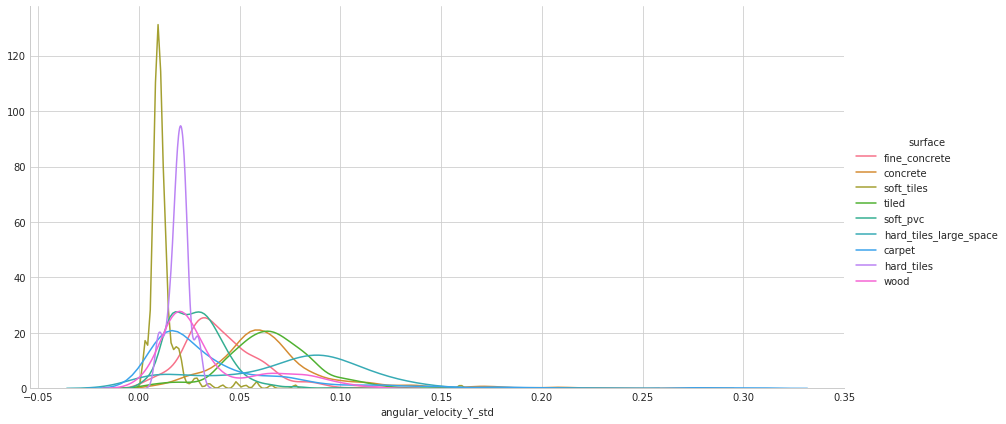

In [100]:
# Distribution of "angular_velocity_Y_std" statistical features for individual classes
sns.set_palette("Set1", desat=0.60)
facetgrid = sns.FacetGrid(final_stat_data, hue='surface', size=6,aspect=2)
facetgrid.map(sns.distplot,"angular_velocity_Y_std", hist=False).add_legend()
plt.show()

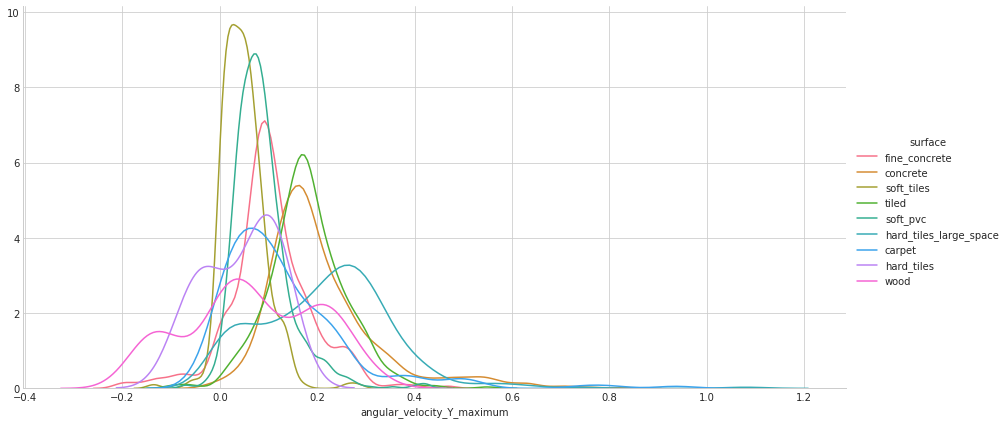

In [101]:
# Distribution of "angular_velocity_Y_maximum" statistical features for individual classes
sns.set_palette("Set1", desat=0.60)
facetgrid = sns.FacetGrid(final_stat_data, hue='surface', size=6,aspect=2)
facetgrid.map(sns.distplot,"angular_velocity_Y_maximum", hist=False).add_legend()
plt.show()

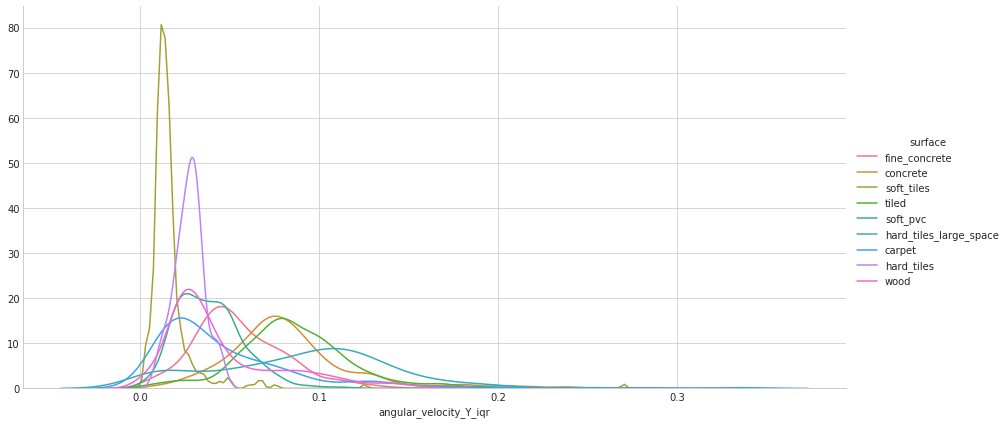

In [102]:
# Distribution of "angular_velocity_Y_iqr" statistical features for individual classes
sns.set_palette("Set1", desat=0.60)
facetgrid = sns.FacetGrid(final_stat_data, hue='surface', size=6,aspect=2)
facetgrid.map(sns.distplot,"angular_velocity_Y_iqr", hist=False).add_legend()
plt.show()

__ Observations__:
- In all plot "hard_tiles" and "soft_tiles" surfaces has a clean separation between the distribution. 
- The "soft_tiles" surface tend to have more peaked distribution than any other surfaces.
- The "carpet" surface has more right skewed when compared to any other distrbution.
- The "hard_tile_large_space" surface has more spread when compared to othe surfaces.

* ## Box Plot

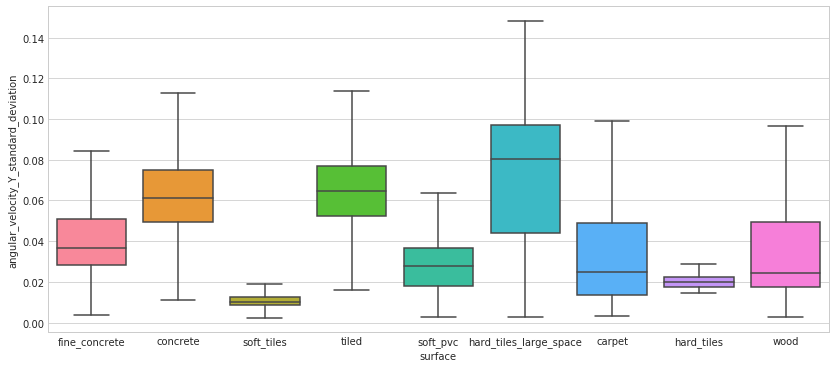

In [83]:
# box plot of "angular_velocity_Y_std" feature for different activities
plt.figure(figsize=(14,6))
sns.boxplot(x='surface', y='angular_velocity_Y_std',data=final_stat_data, showfliers=False, saturation=1)
plt.ylabel('angular_velocity_Y_standard_deviation')
plt.show()

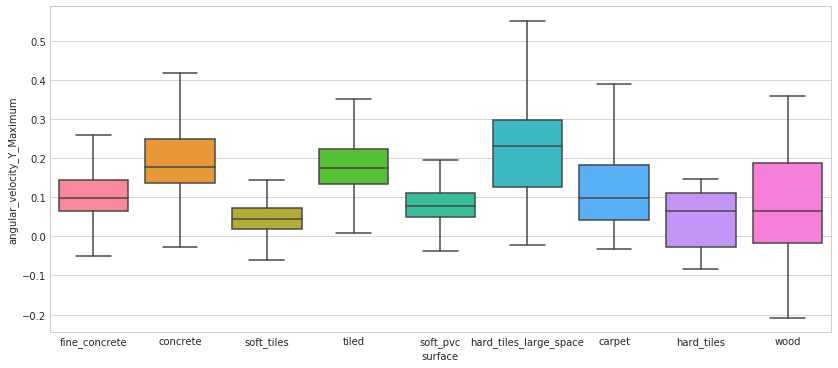

In [86]:
# box plot of "tBodyAccMagmean" feature for different activities
plt.figure(figsize=(14,6))
sns.boxplot(x='surface', y='angular_velocity_Y_maximum',data=final_stat_data, showfliers=False, saturation=1)
plt.ylabel('angular_velocity_Y_Maximum')
plt.show()

__ Observations__:
- The "angular_velocity_Y_std" feature has very low spread and low IQR for "Soft_tile" surface.
- If mean of "hard-tile_large_space" surface in distribution is greater than any other surface.
- The "wood" surface has a low starting point for distribution when compared to other  surface.

* ## Multivariate Analysis by applying T-sne on the data 


performing tsne with perplexity 50 and with 1000 iterations at max
Done..


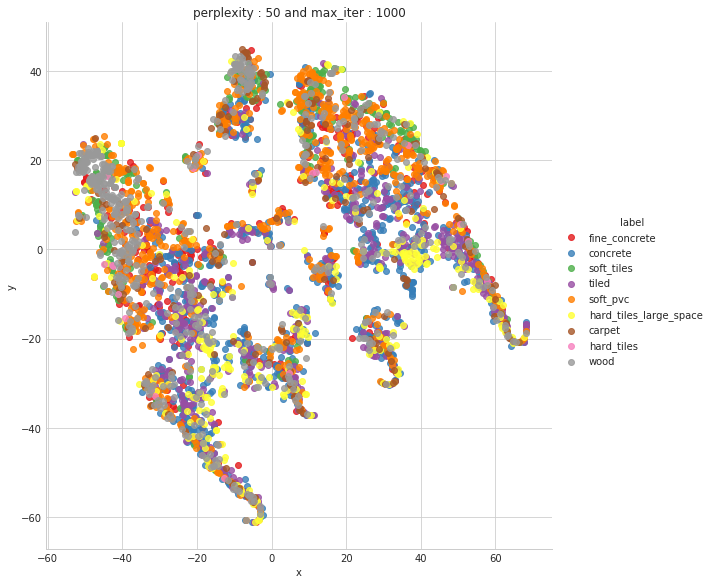

Done


In [106]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# performs t-sne with different perplexity values and their repective plots..
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=0, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        
        # prepare the data for seaborn         
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1")
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        plt.show()
        print('Done')

# function_call        
X_pre_tsne = final_stat_data.drop(['surface'], axis=1)
y_pre_tsne = final_stat_data['surface']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[50],n_iter=1000)

**Observation:**
* Not all class variables are able to group into one single cluster.
* From t-sne plot we come to know that there is more better Feature Extraction needed to build a efficient Model.

In [1]:
#encoding class labels
le = preprocessing.LabelEncoder()
le.fit(y)
unique_labels=le.classes_
encoded_y=le.transform(y)
le_class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_class_mapping)

{'carpet': 0, 'concrete': 1, 'fine_concrete': 2, 'hard_tiles': 3, 'hard_tiles_large_space': 4, 'soft_pvc': 5, 'soft_tiles': 6, 'tiled': 7, 'wood': 8}


# Engineering Fourier Features for each signals:
* **Fourier Transformation** is computed on a time domain signal to check its behavior in the frequency domain. Fourier transformation finds its application in disciplines such as signal and noise processing, image processing, audio signal processing, etc.<br>
* **SciPy** offers the fftpack module, which lets the user compute fast Fourier transforms.

In [108]:
# Reshaping data to feature extration 
X_train_data = pd.read_csv("X_train.csv")
def dataset_for_nn(X_dataset):
    num_samples = X_dataset.shape[0]//128
    X_dataset_for_nn = np.zeros((num_samples,128,10))
    for i in range(num_samples):
        subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        X_dataset_for_nn[i,:,:] = subset
    return X_dataset_for_nn
X_train_for_nn = dataset_for_nn(X_train_data)

# computing fourier transform features of the data
def freqs(dataset,width):
    X = np.abs(fftpack.fft(dataset))
    squeezed_dataset = []
    for i in range(64//width):
        squeezed_dataset.append(np.mean(X[i*width:(i+1)*width]))
    return squeezed_dataset

# function to extract features
def X_features(X_dataset,width=3):
    num_samples = len(list(set(X_dataset["series_id"])))
    num_cols = 64//width
    features = np.zeros((num_samples,110+10*num_cols))
    for i in range(num_samples):
        X_train_subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        for j in range(X_train_subset.shape[1]):
            features[i,110+j*num_cols:110+(j+1)*num_cols] = freqs(X_train_subset[:,j],width)
    return features
X_train_features = X_features(X_train_data)

# Merge statistical features and fourier transform features
for i in range(final_feat_array.shape[0]):
    for j in range(final_feat_array.shape[1]):
        X_train_features[i][j]=final_feat_array[i][j]

In [122]:
# preparing column names for data
fourier_col_names=[]
for i in range(0,210):
    fourier_col_names.append(("fourier_{}".format(i)))
print(fourier_col_names[0:5])

['fourier_0', 'fourier_1', 'fourier_2', 'fourier_3', 'fourier_4']


In [126]:
# Preparing final data frame
col=column_names+fourier_col_names
stat_fourier_data=pd.DataFrame(X_train_features, columns=col)
stat_fourier_labels=pd.DataFrame(y, columns=["surface"])
final_stat_fourier_data=pd.merge(stat_fourier_data,stat_fourier_labels, left_index=True, right_index=True)
final_stat_fourier_data.head(5)

,orientation_X_mean,orientation_X_median,orientation_X_variance,orientation_X_std,orientation_X_maximum,orientation_X_minimum,orientation_X_iqr,orientation_X_cov,orientation_X_skew,orientation_X_kurtosis,...,fourier_201,fourier_202,fourier_203,fourier_204,fourier_205,fourier_206,fourier_207,fourier_208,fourier_209,surface
0,-0.758666,-0.758530,1.305228e-07,0.000361,-0.75822,-0.75953,0.000560,-0.000476,-0.651333,-0.667740,...,4.830429,5.071317,2.523349,2.519509,4.654222,2.858120,3.025013,0.898327,2.134959,fine_concrete
1,-0.958606,-0.958595,2.272771e-08,0.000151,-0.95837,-0.95896,0.000240,-0.000157,-0.392618,-0.664664,...,10.285992,11.175219,6.367436,3.830160,5.831377,2.855389,5.720997,7.064644,2.054695,concrete
2,-0.512057,-0.512035,1.882604e-06,0.001372,-0.50944,-0.51434,0.002162,-0.002680,0.150184,-1.058422,...,9.172233,10.511338,4.048582,1.750979,5.291073,1.992469,2.119604,1.259306,1.690398,concrete
3,-0.939169,-0.939170,5.127256e-08,0.000226,-0.93884,-0.93968,0.000380,-0.000241,-0.094976,-1.082946,...,25.663412,13.435561,8.236136,10.201608,10.852678,4.364610,6.573872,6.587937,3.425676,concrete
4,-0.891301,-0.890940,8.665666e-06,0.002944,-0.88673,-0.89689,0.005045,-0.003303,-0.224035,-1.167403,...,1.009887,0.661228,1.141135,1.110034,1.313324,1.635854,0.539470,0.567330,0.788589,soft_tiles


# Exploratory Data Analysis on Fourier Features

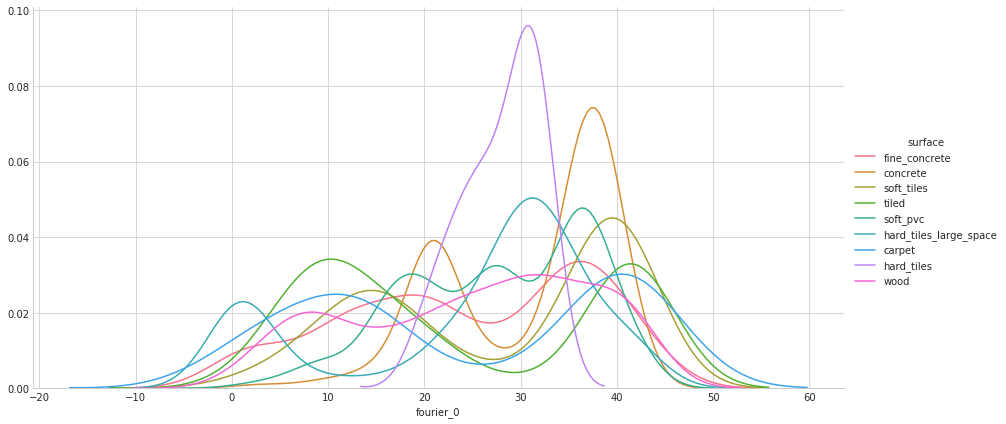

In [133]:
# Fourier features distribution
sns.set_palette("Set1", desat=0.60)
facetgrid = sns.FacetGrid(final_stat_fourier_data, hue='surface', size=6,aspect=2)
facetgrid.map(sns.distplot,"fourier_0", hist=False).add_legend()
plt.show()

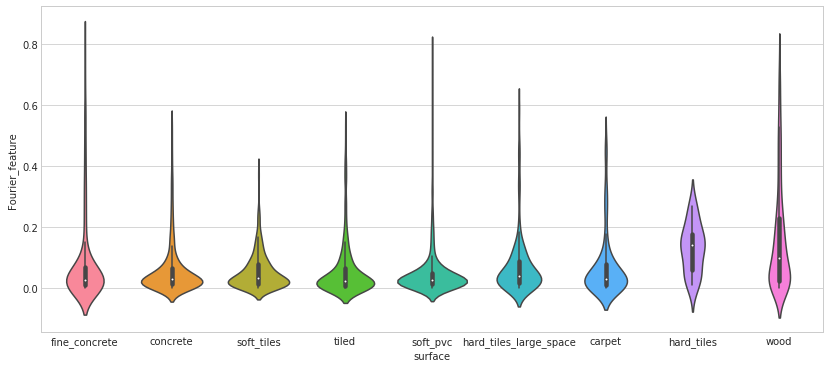

In [150]:
#  violin_plot feature for different surface
plt.figure(figsize=(14,6))
sns.violinplot(x='surface', y='fourier_1',data=final_stat_fourier_data, showfliers=False, saturation=1)
plt.ylabel('Fourier_feature')
plt.show()

** observation: **
* The Fourier features have more variation of distribution on data.
* Now we can combine both statistical and Fourier features to build a Model. 

** Conclusion: **
* The Data does not contain any Dulicates or Null/Nan values.
* The Dataset is slightely Imbalanced amount classes.
* From univariate analysis there is a good seperation between the Soft and Hard Surface.
* T-sne visualization contain points overlaped between some of the class variables.